In [105]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [51]:
# Chargement du script d'importation et formattage des images
%run ./data-importation-and-formatting-v2.py

In [74]:
# Chargement du script de séparation des données
%run ./train_val_test_split.py

In [2]:
data_folder = "../data"
conditions = ["Viral Pneumonia", "Lung_Opacity", "COVID",  "Normal"]
img_folder = "images"

lst_dirs_condition = [os.path.join(data_folder, cond, "images") for cond in conditions]

list_dir_images = pd.DataFrame({"img_type" : ["Viral Pneumonia", "Bacterial Pneumonia", "Covid", "Normal"],
                                 "img_dir" : lst_dirs_condition})


## Importation et préparation des données

In [72]:
## Importation des images

masked_img_df = load_masked_img_multiple_cond_in_df(selected_conditions=conditions, sample_sizes=[1250, 1250, 2500, 2500])


In [78]:
masked_img_df.replace({'Viral Pneumonia' : 'Pulmonary infection',
                       'Lung_Opacity' : 'Pulmonary infection'}, inplace=True)

In [79]:
masked_img_df.label.value_counts()

Pulmonary infection    2500
COVID                  2500
Normal                 2500
Name: label, dtype: int64

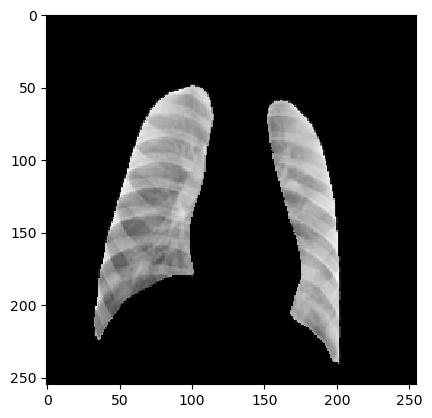

In [73]:
plt.imshow(np.array(masked_img_df.drop(columns='label').iloc[0,:]).reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

## Séparation en échantillons d'apprentissage, de validation et de test

In [99]:
# Encodage de la variable cible en numérique
labenc = LabelEncoder()
y = labenc.fit_transform(masked_img_df.label)

# Séparation des échantillons
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(masked_img_df.drop(columns='label'), 
                                                                      y,
                                                                      test_val_sizes=(0.2, 0.2), random_state=42)

In [98]:
labenc.classes_

array(['COVID', 'Normal', 'Pulmonary infection'], dtype=object)

In [90]:
print(X_train.shape[0],X_train.shape[0]/7500)
print(X_val.shape[0], X_val.shape[0]/7500)
print(X_test.shape[0], X_test.shape[0]/7500)


4800 0.64
1200 0.16
1500 0.2


## Extraction de features à l'aide d'une PCA

In [102]:

# PCA conservant 90 % de l'information
pca90_masks = PCA(n_components=0.9, random_state=42)

X_train_pca = pca90_masks.fit_transform(X_train)

print(X_train_pca.shape) # 345 composants

X_val_pca = pca90_masks.transform(X_val)

print(X_val_pca.shape)

(4800, 345)
(1200, 345)


## Modèle knn optimisé

### Apprentissage

In [103]:
# Instanciation
knn_pca_masks = neighbors.KNeighborsClassifier()

# Optimisation des paramètres
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
folds = list(skf.split(X_train_pca, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

# grid_param = {'metric' : ['euclidean', 'chebyshev', 'correlation', 'cosine'],  'n_neighbors' : [2, 3, 5, 10, 50, 100]}
grid_param = [
    {'metric' : ['minkowski'],  'n_neighbors' : [2, 3, 5, 10, 50], 'p' : [1,2,5]},
    {'metric' : ['chebyshev'], 'n_neighbors' : [2, 3, 5, 10, 50]},
    {'metric' : ['correlation'], 'n_neighbors' : [2, 3, 5, 10, 50]},
    {'metric' : ['cosine'], 'n_neighbors' : [2, 3, 5, 10, 50]}
]
grid_knn_masks = GridSearchCV(knn_pca_masks, param_grid = grid_param, cv=folds)
grid_knn_masks.fit(X_train_pca, y_train)

print(grid_knn_masks.best_params_)

{'metric': 'correlation', 'n_neighbors': 10}


### Evaluation des performances sur l'échantillon de validation

In [108]:
print("Score entraînement :",grid_knn_masks.score(X_train_pca, y_train))

print("Score validation :",grid_knn_masks.score(X_val_pca, y_val))

print("\n Performances et matrice de confusion sur l'échantillon de validation :")

y_val_best = grid_knn_masks.predict(X_val_pca)
# print("f1_score validation :",f1_score(y_val, y_val_best))

print(classification_report(y_val, y_val_best))
pd.crosstab(y_val_best, y_val, rownames=['pred'], colnames=['true'])

# Les résultats sont très bons dans l'identification des images COVID (f1-score à 0.99), mais les données dans l'échantillon d'apprentissage sont déséquilibrées (près de 75% de COVID), ce qui
# biaise les résultats.

Score entraînement : 0.7360416666666667
Score validation : 0.66

 Performances et matrice de confusion sur l'échantillon de validation :
              precision    recall  f1-score   support

           0       0.58      0.66      0.61       371
           1       0.63      0.71      0.67       391
           2       0.81      0.61      0.70       438

    accuracy                           0.66      1200
   macro avg       0.67      0.66      0.66      1200
weighted avg       0.68      0.66      0.66      1200



true,0,1,2
pred,,,
0,245,85,96
1,91,279,74
2,35,27,268
